In [1]:
from rembg import remove
import cv2
from PIL import Image, ImageDraw, ImageChops,ImageEnhance, ImageFilter
from pathlib import Path
import numpy as np
import random
import scipy
from datetime import datetime
import glob, os

In [2]:
class_id_to_name = {
    "0" : "plastic",
    "1" : "paper",
    "3" : "metal",
    "4" : "glass",
    "5" : "cardboard",
}

name_to_class_id = { v:k for k,v in class_id_to_name.items()}

In [3]:
name_to_class_id

{'plastic': '0', 'paper': '1', 'metal': '3', 'glass': '4', 'cardboard': '5'}

In [20]:
def poly_area(x,y):
    """
    Calculates the area of the polygon bounded by counter-clockwise set of point (x[i],y[i])

    :param x: numpy array of x coordinates
    :param y: numpy array of y coordinates
    :return: float
    """
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)


def get_frame(image_path):
    """
    Locates a frame around an object on a (almost) black background

    :param image_path: path to an image, numpy array or an Pillow image
    :return: top-left corner, width, height
    """
    if isinstance(image_path, str):
        image = Image.open(image_path)
    elif isinstance(image_path, np.ndarray):
        image = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
    else:
        image = image_path

    img = image.convert('RGBA')
    datas = img.getdata()

    L=(datas.size[0],0)
    R=(0,0)
    T=(0,0)
    B=(0,datas.size[1])
    for i in range(datas.size[0]):
        for j in range(datas.size[1]):
            item = datas.getpixel((i,j))
            if item[0] > 15 and item[1] > 15 and item[2] > 15:
                if i<L[0]:
                    L=(i,j)
                if i>R[0]:
                    R=(i,j)
                if j>T[1]:
                    T=(i,j)
                if j<B[1]:
                    B=(i,j)
    X = (L[0],B[1])
    w = R[0]-L[0]
    h = T[1]-B[1]
    return X, w, h


def remove_background(image_path):
    """
    Makes all (almost) black pixels of the image completely transparent

    :param image_path: path to an image, numpy array or an Pillow image
    :return: a Pillow image. If the input is a path to an image, it also saves the result
    """
    k=1
    if isinstance(image_path, str):
        k = 2
        image = Image.open(image_path)
    elif isinstance(image_path, np.ndarray):
        image = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
    else:
        image = image_path

    image = image.convert('RGBA')
    datas = image.getdata()
    new_data = datas

    for i in range(datas.size[0]):
        for j in range(datas.size[1]):
            item = datas.getpixel((i,j))

            #Here we can choose what colors we want to override with the transperent pixel
            if item[0] < 15 and item[1] < 15 and item[2] < 15:
                new_data.putpixel((i,j),(0,0,0,0))
            else:
                new_data.putpixel((i,j), item)
    image.putdata(new_data)
    if k == 2:
        image.save(Path(image_path).stem+"_transparent.png", "PNG")
    return image

def find_coeffs2(src, dst):
    """ Creates a perspective transformation matrix which transforms points
        in quadrilateral ``src`` to the corresponding points on quadrilateral
        ``dst``.

        Will raise a ``np.linalg.LinAlgError`` on invalid input.
        """
    # See:
    # * http://xenia.media.mit.edu/~cwren/interpolator/
    # * http://stackoverflow.com/a/14178717/71522
    in_matrix = []
    for (x, y), (X, Y) in zip(src, dst):
        in_matrix.extend([
            [x, y, 1, 0, 0, 0, -X * x, -X * y],
            [0, 0, 0, x, y, 1, -Y * x, -Y * y],
        ])

    A = np.matrix(in_matrix, dtype=np.float32)
    B = np.array(dst).reshape(8)
    af = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.append(np.array(af).reshape(8), 1)[:-1]


def find_coeffs(pa, pb):
    """
    Finds the matrix coefficients of the perspective transform from pa to pb

    :param pa: 4 pairs of (x,y)
    :param pb: 4 pairs of (x,y)
    :return: np.array of length 8
    """
    matrix = []
    
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float32)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)


def add_perspective(image, tilt=0, offset=(0, 0), alpha=0):
    """
    Applies a perspective transform according to the inputs given and saves it

    :param image_path: path to the image
    :param tilt: applies a percentage tilt to the top edge of the frame
    :param offset: applies a percentage offset to the top edge of the frame
    :param alpha: applies a percentage shrink to the top edge of the frame
    :return: Pillow image, frame of the newly transformed object
    """
    X, w, h = get_frame(image)
    #initializes the 4 corners of the frame in the appropriate form and order
    input_pts = np.float32((X, [X[0] + w, X[1]], [X[0], X[1] + h], [X[0] + w, X[1] + h]))
    P1 = [0, 0]
    P2 = [0, 0]

    #transformes the points
    P1[0] = input_pts[0][0] + int(offset[0] * w) + int(alpha * w)
    P2[0] = input_pts[1][0] + int(offset[0] * w) - int(alpha * w)
    P1[1] = input_pts[0][1] + int(offset[1] * h) + int(tilt * h)
    P2[1] = input_pts[1][1] + int(offset[1] * h) - int(tilt * h)
    output_pts = np.float32(([P1, P2, input_pts[2], input_pts[3]]))

    #get the coefficients of the transformation matrix
    coeffs = find_coeffs(input_pts, output_pts)

    image = image.transform((image.size[0], image.size[1]), Image.PERSPECTIVE, coeffs,
        Image.BICUBIC)

    return image, get_frame(image)


def random_partition_V1(n, cnt):
    """
    Returns an array of equidistant spacing with a random uniform shortenings

    :param n: length to shorten
    :param cnt: number of divisions
    :return: numpy array
    """
    terms=[]
    for i in range(cnt):
        terms.append(random.randint(1, n//cnt))
    return np.array([int(i) for i in terms])+n//cnt


def random_partition_V3(n, cnt):
    """
    Returns an array of equidistant spacing with a random beta-distribution shortenings

    :param n:
    :param cnt:
    :return:
    """
    x = np.array([n/cnt]*cnt)
    y = np.random.beta(4,2,cnt)*(n/cnt)*0.7
    return x-y


def crumbled_meshgrid(X, w, h, density):
    """
    Creates a perturbed meshgrid of the frame provided using random_partition_V3.
    :param X: coordinates of the top-left corner of the frame as (x,y)
    :param w: width of the frame
    :param h: height of the frame
    :param density: density of the grid
    :return: 2 2D numpy arrays
    """
    xm = np.zeros(shape=(density, density))
    ym = np.zeros(shape=(density, density))
    for i in range(density):
        xm[i, :] = np.array(random_partition_V3(w, density)).cumsum()

        ym[:, i] = np.array(random_partition_V3(h, density)).cumsum()
    return xm + X[0], ym + X[1]


def expand_pts(pts, a):
    """
    Applies an expansion of the 4 points from the center by a

    :param pts: 4 points like (x,y) ordered counter-clockwise
    :param a: float
    :return: shifted points
    """
    if (pts + np.array([[-0, -0], [-0, 0], [a, a], [a, -a]]) < 0).any():
        return pts
    return pts + np.array([[-0, -0], [-0, 0], [a, a], [a, -a]])


def crunch(image_path, density=2):
    """
    Creates a crunched object

    :param image_path: path to the image
    :param density: density of the meshgrid
    :return: transformed image
    """

    image = cv2.imread(image_path)

    #We define the sharpening kernel, since the future process involves interpolation.
    kernel = np.full((3, 3), 0)
    kernel[1, 1] = 5
    kernel[0, 1] = -1
    kernel[1, 0] = -1
    kernel[2, 1] = -1
    kernel[1, 2] = -1
    image = cv2.filter2D(image, -1, kernel)

    #We define the crumbled_meshgrid
    X, w, h = get_frame(image_path)
    xm, ym = crumbled_meshgrid(X, w, h, density)
    mask = np.zeros(shape=image.shape, dtype=np.uint8)
    xl = np.linspace(X[0], X[0] + w, density)
    yl = np.linspace(X[1], X[1] + h, density)

    xv, yv = np.meshgrid(xl, yl)

    #Area of a regular meshgrid.
    area = poly_area(np.array((xv[0, 0], xv[1, 0], xv[1, 1], xv[0, 1])),
                     np.array((yv[0, 0], yv[1, 0], yv[1, 1], yv[0, 1])))

    dst1 = np.zeros(shape=image.shape, dtype=np.uint8)
    dst2 = np.zeros(shape=image.shape, dtype=np.uint8)

    #We create the crumbled picture tile by tile.
    for i in range(density - 1):
        for j in range(density - 1):

            pts = np.array([[xm[i, j], ym[i, j]], [xm[i + 1, j], ym[i + 1, j]], [xm[i + 1, j + 1], ym[i + 1, j + 1]],
                            [xm[i, j + 1], ym[i, j + 1]]], np.int32)
            Pts = np.float32(pts)
            pts = pts.reshape((-1, 1, 2))

            #Area of the transformed tile. We will use it for creating shadows.
            tarea = poly_area(np.array((xm[i, j], xm[i + 1, j], xm[i + 1, j + 1], xm[i, j + 1])),
                              np.array((ym[i, j], ym[i + 1, j], ym[i + 1, j + 1], ym[i, j + 1])))
            gray = min(255, int(tarea / area * 255) + 170)

            #We create a mask which will darken the warped image appropriately.
            cv2.fillConvexPoly(mask, pts, color=(gray, gray, gray))

            M = cv2.getPerspectiveTransform(np.float32(
                [[xv[i, j], yv[i, j]], [xv[i + 1, j], yv[i + 1, j]], [xv[i + 1, j + 1], yv[i + 1, j + 1]],
                 [xv[i, j + 1], yv[i, j + 1]]]),
                                            Pts)
            #We warp the picture and take the tile out and put it on the final image
            temp_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
            small_mask = np.zeros(shape=image.shape[:2], dtype=np.uint8)
            pts_expanded = np.int32(expand_pts(np.int32(Pts), 0.5))
            cv2.fillConvexPoly(small_mask, pts_expanded, 1)
            dst1 = cv2.add(dst1, cv2.bitwise_and(temp_image, temp_image, mask=small_mask))

            #This is the same warped picture, but the edges are a bit smaller and result in holes
            small_mask = np.zeros(shape=image.shape[:2], dtype=np.uint8)
            pts_expanded = np.int32(expand_pts(np.int32(Pts), -0.5))
            cv2.fillConvexPoly(small_mask, pts_expanded, 1)
            dst2 = cv2.add(dst2, cv2.bitwise_and(temp_image, temp_image, mask=small_mask))

    #Here we try to remove the "net"
    mean = np.mean(image[image != 0])*1.8
    dst = cv2.addWeighted(dst1, 1 - mean / 256, dst2, mean / 256, 0)

    #This filter helps a bit
    dst = cv2.bilateralFilter(dst, 40, 15, 15)

    #We need to change to Pillow to use multiply
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = Image.fromarray(mask)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    dst = Image.fromarray(dst)
    dst = ImageChops.multiply(dst, mask)
    
    enh = ImageEnhance.Brightness(dst)
    dst = enh.enhance(1.2)

    # dst = add_shadow(dst)
    return dst


def add_shadow(image):
    """
    Adds a rectangular shadow of random opacity and position

    :param image: Pillow image
    :return: Pillow image
    """
    draw = ImageDraw.Draw(image, "RGBA")
    cX = random.uniform(100, image.size[0])
    cY = random.uniform(100, image.size[1])
    r = 150
    phi = int(random.uniform(0,360))
    opacity = random.uniform(20,128)
    draw.regular_polygon((cX,cY,r), 4, phi, fill=(0,0,0,int(opacity)), outline=None)
    return image


def synthethic_picture(background_path, object_path, density=10, t=255, cr=0):
    """
    Randomly puts a crunched object on the background

    :param background_path: path to a .png
    :param object_path: path to a .jpg
    :param density: mesgrid resolution
    :return: position of the top-left corner of the frame, it's width, it's height, image path
    """
    bckg = Image.open(background_path)
    bckg = bckg.convert("RGBA")
    check = random.uniform(0,1)
    if check<cr:
        crunched = crunch(object_path, density)
    else:
        crunched = Image.open(object_path)

    crunched = remove_background(crunched)
    phi = random.uniform(0, 360)
    crunched = crunched.rotate(phi)
    
    offset = (random.uniform(0, 0.05), random.uniform(0, 0.05))
    tilt = random.uniform(0, 0.1)
    alpha = random.uniform(0, 0.1)
    crunched, (X, w, h) = add_perspective(crunched, tilt, offset, alpha)
    
    if t!=255:
        crunched = make_transperent(crunched, t)
        
    insert_X = random.uniform(-X[0], bckg.size[0] - X[0] - w)
    insert_Y = random.uniform(-X[1], bckg.size[1] - X[1] - h)
    new_image = bckg.copy()
    new_image.paste(crunched, (int(insert_X), int(insert_Y)), crunched)
    path = Path(object_path).stem + datetime.now().strftime("%H%M%S") + ".png"
    new_image.save(path)
    return np.array(X) + np.array([int(insert_X), int(insert_Y)]), w, h, path


def create_yolo_txt_file(image_path, X, w, h):
    """
    Creates a .txt file in the same directory as the image_path with a yolo format of the object frame

    :param image_path: path to the image
    :param X: top-left corner of the frame as (x,y)
    :param w: width of the frame
    :param h: height of the frame
    """
    img = Image.open(image_path)
    name = Path(image_path).stem
    name_alpha = ''.join([i for i in name if not i.isdigit()])
    cX = (X[0]+w/2)/img.size[0]
    cY = (X[1]+h/2)/img.size[1]
    w = w/img.size[0]
    h = h/img.size[1]
    with open(str(Path(image_path).parent)+"/"+name+".txt", "w") as f:
        kind = name_to_class_id[name_alpha]
        f.write(str(kind) + " " + str(cX) + " " + str(cY) + " " + str(w) + " " + str(h))


def make_transperent(obj, t=255):
    im = obj
    datas = im.getdata()
    new_data = datas
    for i in range(datas.size[0]):
        for j in range(datas.size[1]):
            item = datas.getpixel((i,j))

            #Here we can choose what colors we want to override with the transperent pixel
            if item[0] < 15 and item[1] < 15 and item[2] < 15:
                new_data.putpixel((i,j),(0,0,0,0))
            elif abs(item[0]-item[1])<20 and abs(item[0]-item[2])<20:
                new_data.putpixel((i,j), (item[0],item[1], item[2], int(t*(255-item[1])/255+40)))
            else:
                new_data.putpixel((i,j), (item[0],item[1], item[2], int(t)))
    im.putdata(new_data)
    return im
        
def create_dataset(back_path, obj_path, density=10, t=255, per_background=400, mapping=None, cr=0):
    if mapping is None:
        mapping = dict()
        for f in os.listdir(back_path):
            mapping[f] = combos(obj_path, per_background)
    for b, o in mapping.items():
        background = back_path + "/" + b
        for obj in o:
            trash = obj_path + "/" + obj
            X, w, h, path = synthethic_picture(background, trash, t=t, density=density, cr=cr)
            create_yolo_txt_file(path, X, w, h)

In [5]:
def bck_remove(folder_path):
    os.chdir(folder_path)
    for image in glob.glob("*.jpg"):
        input = cv2.imread(image)
        output = remove(input)
        im = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        im = Image.fromarray(im)
        datas = im.getdata()
        new_data = datas
        for i in range(datas.size[0]):
            for j in range(datas.size[1]):
                item = datas.getpixel((i,j))

                #Here we can choose what colors we want to override with the transperent pixel
                if item[0] < 15 and item[1] < 15 and item[2] < 15:
                    new_data.putpixel((i,j),(0,0,0,0))
                else:
                    new_data.putpixel((i,j), item)
        im.save(image[:-4]+".png")

In [6]:
def combos(folder_path, max_entries=5):
    names = os.listdir(folder_path)
    n = np.random.randint(1,max_entries*1.5)
    return random.choices(names, k=n)

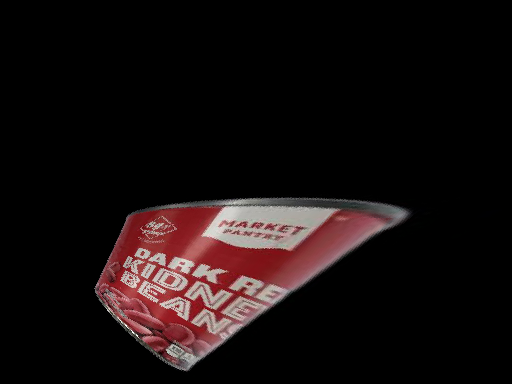

In [67]:
image, frame = add_perspective(Image.open("C:/Users/W78P/Documents/Python Scripts/test/metal62.jpg"), tilt=-0.9, offset=(0.5, -0.3), alpha=-0.05)
image.rotate(40)

In [7]:
transform_folder("C:/Users/W78P/Documents/Python Scripts/test")

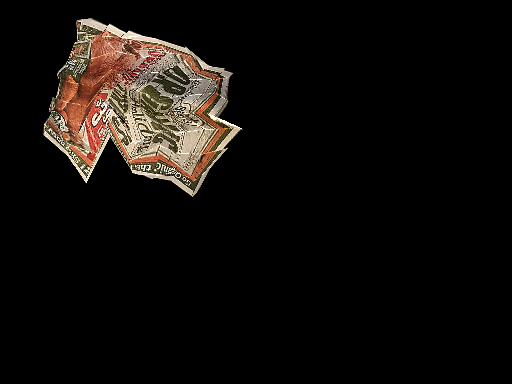

In [37]:
crunch("C:/Users/W78P/Documents/Python Scripts/test/paper586.png", 10)

In [2]:
def jpg_to_png(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image.save(Path(image_path).stem + ".png")

for i in glob.glob("C:/Users/W78P/Documents/Python Scripts/background/*.jpg"):
    jpg_to_png(i)

In [14]:
create_dataset("C:/Users/W78P/Documents/Python Scripts/backgrounds/", "C:/Users/W78P/Documents/Python Scripts/vcr_ntr/", density=16, per_background=5, t=255, cr=0.8)

In [ ]:
for i in glob.glob("C:/Users/W78P/Documents/Python Scripts/backgrounds/*"):
    img = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(i, resized)